# Classifying 3x3 mazes - Using symmetry
In this notebook we use the same Quantum Machine Learing approach as for the Tic-Tac-Toe boards, but for a different application: determining whether a path exists between any two corners of a 3x3 maze. The following cells show some examples, where the mazes are colored green or red depending on whether it is solvable or not, respectively.

In [5]:
from qiskit import *
import numpy as np
import maze as m

from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)


def make_circuit(x, params, layers):
    circ = QuantumCircuit(9)
    p = 0.01
    noise_model = NoiseModel()
    for qubit in range(9):
        bit_flip = pauli_error([('X', p), ('I', 1 - p)])
        phase_flip = pauli_error([('Z', p), ('I', 1 - p)])
        noise_model.add_quantum_error(bit_flip, 'x', [qubit])
        noise_model.add_quantum_error(phase_flip, 'z', [qubit])
    circ.noise_model = noise_model
    for i in range(layers):
        l = i*9
        m.encode_data(x, circ)
        m.add_single_qubit_gates(params[l:l+6], circ)
        m.add_two_qubit_gates(params[l+6:l+9], circ)

    return circ
# Create a Quantum Circuit acting on a quantum register of nine qubits

layers = 4

params = np.random.rand(9*layers)*2*np.pi
circ = make_circuit([1,1,0,0,0,1,0,0,0], params, layers)

maze_fields, grid_combinations = m.generate_maze_field()

In [6]:
# Define the loss function
def l2_loss(output, target):
    output, target = np.array(output), np.array(target)
    return np.abs(output - target)**2

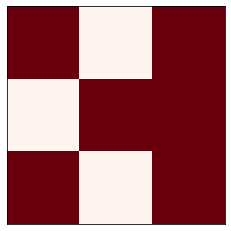

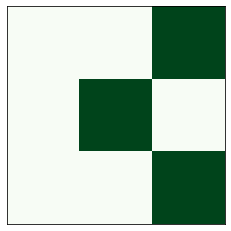

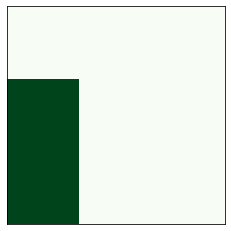

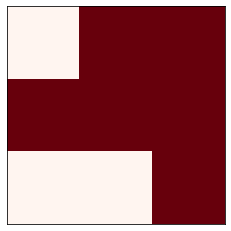

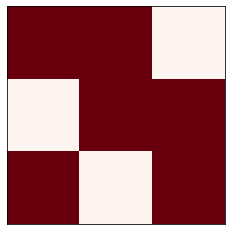

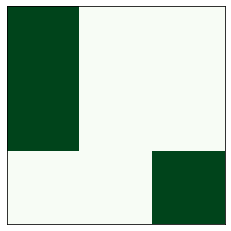

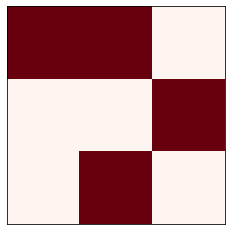

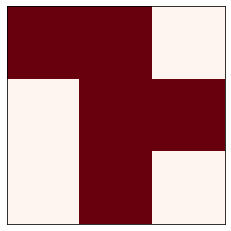

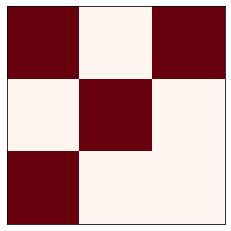

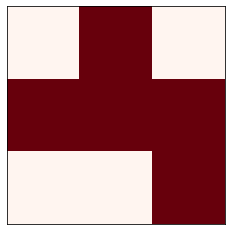

In [7]:
x = maze_fields
y = m.check(grid_combinations)
#print(x)
#print(y)

# shuffle the indices
shuffle_indices = np.random.permutation(len(x))
train_size = int(len(x) * 0.3)

# split the indices into training and testing sets
train_indices = np.array(shuffle_indices[:train_size])
test_indices = np.array(shuffle_indices[train_size:])

# create the training and testing sets
x_train, y_train = np.take(x, train_indices, axis=0), np.take(y, train_indices, axis=0)
x_test, y_test = np.take(x, test_indices, axis=0), np.take(y, test_indices, axis=0)

for maze in x[:10]:
    m.plot_maze(maze)

### Run the optimization

In [8]:
from tqdm import tqdm
# Define the optimizer
from qiskit.algorithms.optimizers import SPSA
optimizer = SPSA(maxiter = 100)

# Define the cost function to be minimized by the optimizer
def cost_function(params):

    cost = 0
    estimator = Estimator()
    observables = (
        SparsePauliOp("IIIIZIIII")
    )
    
    for x, y in zip(x_train, y_train):
        # Create a Quantum Circuit acting on a quantum register of nine qubits
        circ = make_circuit(x, params, layers)        

        circuits = (
            circ,
        )

        job = estimator.run(circuits, observables)
        result = job.result().values[0]
        
        prediction = (result + 1)/2
        
        cost += l2_loss(prediction, y)
        
    print(cost)
    return cost

# Initialize the parameters
params = np.random.rand(9*layers)*2*np.pi

# Train the circuit
print('Initial parameters:', params)

# Check the qiskit docs to figure out how to start an optimizer
result = optimizer.minimize(cost_function, x0 = params)
print("Finished optimization.")

Initial parameters: [2.66842631 4.8846911  2.68191017 1.79025947 3.48852204 1.53658674
 0.75552037 3.72404799 3.19123273 1.18275003 2.66589807 2.37061126
 0.52102629 4.95969118 0.76845825 0.40815113 4.6502502  2.9086798
 3.99176193 1.25576734 0.56627402 5.58964035 4.65209565 3.2753886
 4.4481009  1.98593788 3.85858056 2.79700557 3.27869395 3.20817251
 2.54006901 2.41003705 2.04502204 0.81004736 4.46014954 2.46450228]
33.04324291399726
33.20745440393526
32.65838036216559
33.34372268042215
34.41089234642641
32.78792437168401
33.84785945327441
33.4625338668487
33.75105650195331
32.61611875837937
33.02531332626444
33.35994888077417
33.164694732477585
32.72931766140106
32.455549496070745
33.212678796947905
32.77284647402786
33.05167801396262
32.48372424926208
33.51454673350422
32.23061194561675
33.211039775333674
32.55833317721817
33.055891042898566
32.22387453671108
33.11433753908818
33.16208405119477
33.0589812529777
32.312527797441156
33.49733766619641
32.93289334637625
32.64191816648274

In [9]:
def predict(data, params):
    circ = make_circuit(data, params, layers)

    #TODO:  create observables and measure

    estimator = Estimator()
    observables = (
        SparsePauliOp("IIIIZIIII")
    )
    
    circuits = (
            circ
        )

    job = estimator.run(circuits, observables)
    result = job.result().values[0]
    
    

    return (result + 1)/2

In [10]:
def test_model(params, x_data, y_data):
    total_loss = 0
    correct_guesses = 0
    i = 0
    for x, y in zip(x_data, y_data):
        pred = predict(x, params)
        pred_discrete = round(pred)
        total_loss += l2_loss(pred, y)
        correct_guesses += np.all(pred_discrete == y)
        
        if i % 200 == 0 and False: 
            print("Correct output:", y)
            print("Actual output:", pred)
            print("Discrete_output:", pred_discrete)
            print("---------------")

    total_loss = total_loss / len(x_data)

    print("Correct guesses: {}/{} ({}%)".format(correct_guesses, len(x_data), round(correct_guesses/len(x_data)*100)))
    print("L2 Loss: {}".format(total_loss))
    
print("Train data:")
test_model(result.x, x_train, y_train)

print("Test data:")
test_model(result.x, x_test, y_test)

Train data:
Correct guesses: 89/132 (67%)
L2 Loss: 0.23494196966493286
Test data:
Correct guesses: 172/308 (56%)
L2 Loss: 0.24272333939621787
